## Discussion
This notebook is dedicated to two main problems of the discussion part:  
- Proportion of shared edges between meters *vs* random edges baseline;
- Stability of edges in the network.

In [35]:
library(tidyverse)
library(tidytext)

library(igraph)
library(ggraph)

theme_set(theme_minimal())
library(wesanderson)

In [53]:
# load data
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

topic_labels <- get_topic_labels(beta, n_labels = 5)

# prepare gamma data
gamma <- gamma %>% 
    # select ONLY RNC connections & topics
    filter(corpus == "N") %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

# create edges
edges_raw <- compute_edges(gamma,
                           gamma_thresh = 0.05,
                           time_slice = 5)

# select only RNC edges
edges_raw <- edges_raw %>% 
    #filter(corpus == "N") %>% 
    rename(meter = formula)

# create links
#links <- edges_raw %>% 
#  mutate(meter = formula) %>%
#  # filter out only 8 most interesting meters
#  filter(meter %in% c("iamb_4", "iamb_free", "iamb_6", "iamb_5",
#                     "trochee_4", "iamb_3")) %>% 
#  # group and count edges
#  group_by(slice, meter, corpus) %>% 
#  count(slice, meter, edge_id, source, target, sort = T) %>% 
#  # filter non-frequent edges
#  filter(n > 2) %>% 
#  ungroup() 

#edgelist <- links %>%
#  select(source, target, n, meter, slice)

## build a nodelist
#nodelist <- tibble(source = unique(c(links$target, links$source)))  %>% 
#    mutate(idn=as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))

#head(edgelist)
#head(nodelist)

### Shared edges vs random baseline
  
#### I. Shared connection calculation
Function for pair-wise calculation of connection iou

In [21]:
calculate_real_iou  <- function(x, s = "iamb_4", t) {
    # first, select meters and get edges per time slice
    edges_meters  <- x  %>%
        filter(meter %in% c(s, t)) %>%
        group_by(slice, meter)  %>%
        count(edge_id)  %>% 
      #  filter(n>1)  %>% # filter if you want
        select(-n)


    # prepare a table with two meters as columns and lists of their connections per each time slice
    connections <- edges_meters  %>% 
        ungroup()  %>% 
        nest(edge_id)  %>%
        pivot_wider(names_from = meter, values_from = data)


    # calculate intersection, union, and iou
    int_union  <- connections  %>% 
        rowwise()  %>% 
        mutate(inter=list(intersect(unlist(!! sym(s)), unlist(!! sym(t)))), # intersection of edges
               uni=list(union(unlist(unlist(!! sym(s))), unlist(!! sym(t)))), # union of edges
               iou=length(inter)/length(uni)) # intersection over union


    int_union  <- int_union  %>% select(slice, iou)
    return(int_union)
    }

In [54]:
target_meters  <- c("iamb_free", "iamb_3", "iamb_5", "iamb_6", 
                    "trochee_4")

In [55]:
int_union  <- NULL

suppressWarnings(for (m in target_meters) {

    df <- calculate_real_iou(edges_raw,s = "iamb_4", t = m) %>% 
        mutate(meter = m)

    int_union  <- rbind(int_union,df)  

})

head(int_union)

slice,iou,meter
<dbl>,<dbl>,<chr>
1775,0.08053691,iamb_free
1780,0.11299435,iamb_free
1785,0.05714286,iamb_free
1790,0.16871166,iamb_free
1795,0.20571882,iamb_free
1800,0.20301348,iamb_free


#### II. Randomly sampled connections  
  
1. choose meter for comparison with Iamb-4
1. determine it's size per time slice 
1. sample by sizes from random pool of non-iambs
1. Repeat N times
1. Calculate mean and CI

Start with defining few functions

In [14]:
### sampling

sample_random_edges  <- function(edges_df = edges_raw,
                                 target_meter = "iamb_free") {

    
    pool <- edges_df %>% ungroup()  
    l <- nrow(pool)


    sample_sizes <- edges_raw  %>%
        ungroup()  %>% 
        filter(meter == target_meter) %>%
        count(slice,meter)  %>% 
        select(slice,meter,n)


    df  <- NULL

    for(i in 1:nrow(sample_sizes)) {

        s <- pool[sample(l, sample_sizes$n[i]),]

        edges_random <- s %>%
            count(edge_id) %>% 
            mutate(meter = "random",slice = sample_sizes$slice[i]) %>% 
            select(-n)

        df  <- bind_rows(df,edges_random)
    }

    return(df)   
}

# random intersection calculation
calculate_random_iou <- function(x, i4_df = i4) {
    
    edges_meters <- i4_df %>%
        bind_rows(x)  %>% # bind sample
        group_by(slice,meter)  %>%
        count(edge_id)  %>% 
        select(-n)


    # prepare a table with two meters as columns 
    # and lists of their connections per each time slice
    connections=edges_meters  %>% 
        ungroup()  %>% 
        nest(edge_id)  %>%
        pivot_wider(names_from = meter,values_from = data)



    iou_random  <- connections  %>% 
        rowwise()  %>% 
        mutate(inter=list(intersect(unlist(`iamb_4`), unlist(`random`))), # intersection of edges
               uni=list(union(unlist(`iamb_4`), unlist(`random`))), # union of edges
               iou=length(inter)/length(uni))  %>% # intersection over union  
        select(slice, iou)

    return(iou_random)

}

In [56]:
N = 100

i4  <- edges_raw %>% ungroup() %>% filter(meter == "iamb_4")

iou_ci  <- NULL

suppressWarnings(for(m in target_meters) {

    for(i in 1:N) {
    
        s  <- sample_random_edges(edges_raw,target_meter = m)
    
        iou_random  <- calculate_random_iou(s, i4)  %>% mutate(meter=m)
    
        iou_ci  <- bind_rows(iou_ci, iou_random)  
    }    
})

#### Summarise & plot

In [57]:
iou_ribbon  <- iou_ci %>% 
    group_by(slice, meter) %>%  
    summarise(lower = quantile(iou, 0.025),
              upper = quantile(iou, 0.975),
              iou = mean(iou))

`summarise()` has grouped output by 'slice'. You can override using the
`.groups` argument.


Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


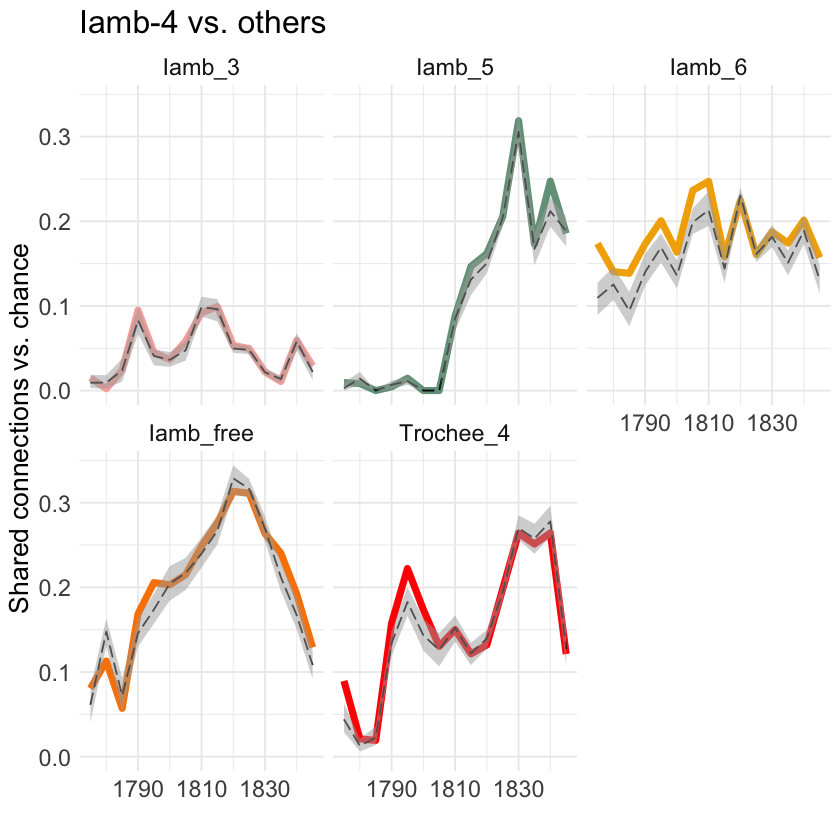

In [59]:
trans_meter  <- tibble(meter = int_union$meter  %>% unique(),
                       meter_t = c("Iamb_free", 
                                   "Iamb_3", 
                                   "Iamb_5", 
                                   "Iamb_6", 
                                   "Trochee_4" ))


int_union %>%
    left_join(trans_meter, by = "meter")  %>% 
    ggplot(aes(slice, iou, color = meter_t)) + 
    geom_line(size = 2) + 
    labs(x = "", 
         y = "Shared connections vs. chance", 
         title="Iamb-4 vs. others") + 
    geom_line(data = iou_ribbon %>% left_join(trans_meter, by = "meter") ,color="black",size=0.5,linetype=5) + 
    geom_ribbon(data = iou_ribbon %>% left_join(trans_meter,by="meter"), aes(slice,iou,color=NULL,ymin=lower,ymax=upper),fill="darkgray",alpha=0.5) +
    facet_wrap(~meter_t) + 
    scale_color_manual(values = c(wes_palette("Royal2")[3],
                                 wes_palette("Royal2")[5],
                                 wes_palette("Darjeeling1")[3],
                                 wes_palette("Darjeeling1")[4],
                                 wes_palette("Darjeeling1")[1])) + 
    guides(color = "none") +
    theme(text = element_text(size = 16),
          axis.text = element_text(size = 14),
          strip.text = element_text(size = 14)) +
    xlim(c(1775,1845))


# saveRDS(iou_ribbon, file="iou_ci.rds")

ggsave("../plots/04_shared_ci.png", width = 10, height = 8,
      dpi = 300, bg = "white")

### II. Connections stability
Trace the presence of most frequent connections in each meter

In [67]:
edges <- edges_raw %>% 
    filter(meter %in% c("iamb_4", "iamb_free", "iamb_6", 
                        "iamb_5", "trochee_4"))

x = edges_raw$meter %>% table()

t <- edges %>% group_by(meter) %>%
  select(meter,slice, from, to) %>% 
  pivot_longer(!c(slice,meter), names_to = "x", values_to = "topic") %>% 
  select(-x) %>% 
  group_by(topic,meter) %>% 
  # frequency filtering
  mutate(n_times=row_number()) %>% 
  filter(n_times > 2) %>% 
  distinct(slice, topic)

Adding missing grouping variables: `index`
Selecting by n
Joining with `by = join_by(meter, edge_id)`


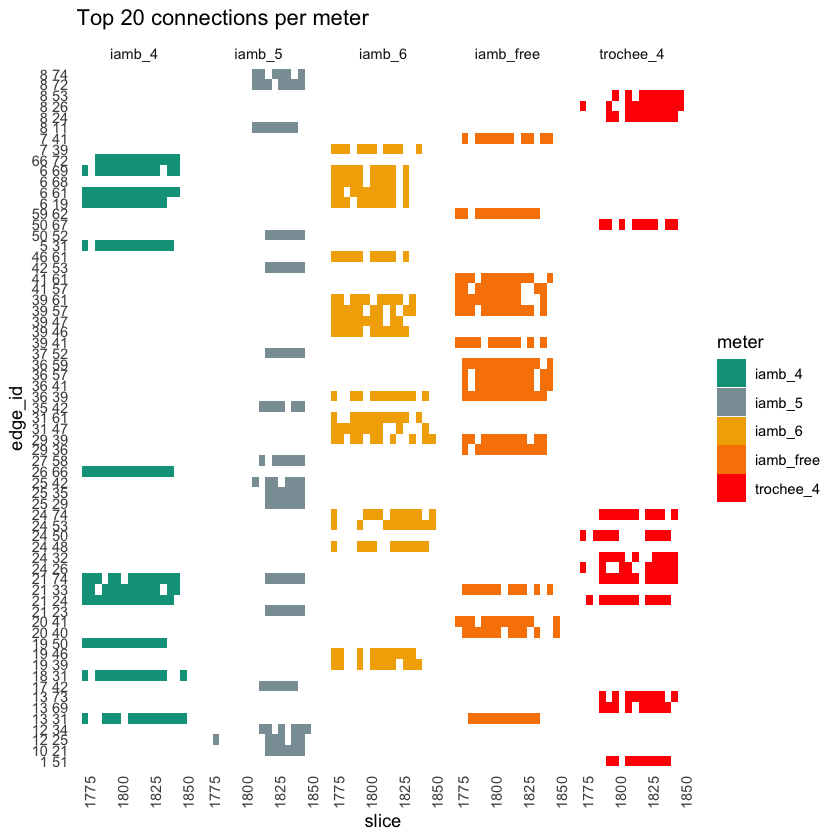

In [71]:
#### connections

c_count <- edges %>% 
  select(meter, slice, edge_id) %>% 
  group_by(edge_id,meter) %>% 
  # frequency filtering
  mutate(n_times = row_number()) %>% 
  distinct(slice, edge_id)

top_connections <- c_count %>%
  group_by(meter, edge_id) %>% 
  count() %>% 
  group_by(meter) %>% 
  top_n(10) %>% mutate(is_top = T)

c_count %>% 
    left_join(top_connections) %>% 
    filter(is_top) %>% 
    ggplot(aes(slice,edge_id, fill = meter)) + 
    geom_tile() + 
    scale_fill_manual(values = c(wes_palette("Darjeeling1")[2],
                                 wes_palette("Royal1")[1],
                                 wes_palette("Darjeeling1")[3],
                                 wes_palette("Darjeeling1")[4],
                                 wes_palette("Darjeeling1")[1])) + 
    theme(axis.text.x = element_text(angle = 90),
          panel.grid = element_blank()) + 
    labs(title="Top 20 connections per meter") + 
    facet_wrap(~meter,ncol=5)

In [72]:
ggsave(file = "../plots/04_connections_stability.png",
      plot = last_plot(),
      width = 10, height = 8,
      dpi = 300, bg = "white")